In [28]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
import tensorflow as tf
%matplotlib inline

# Pre-requisite: create a graph and a signal

We take the minstdigit 9 as signal on a grid

In [29]:
mnist = scipy.misc.imread("mnist.png", flatten=True)/255

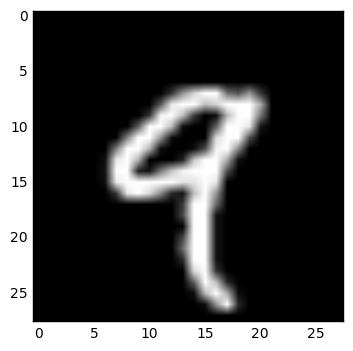

In [30]:
plt.imshow(mnist, cmap='gray')

In [31]:
# reshape the signal to a vector, r
x = mnist.reshape((-1,))

we know want to create a grid: 
    - 

In [32]:
h, w = mnist.shape
W = np.zeros((h*w, h*w))  # empty weight matrix    

In [33]:
def index_to_pixels(i, h, w):
    """i: index, h: image height, w: image width
    returns: pixel height, pixel width
    """
    return (i//h, i%h)

def pixel_to_index(x, y, h, w):
    """x: pixel height, y: pixel width, h: image height, w: image width"""
    return x*h + y

def valid_pixel(x, y, h, w):
    return (0<=x) and (x<h) and (0<=y) and (y<w)

def find_neighbors(i, h, w):
    """i: index, h: image height, w: image width
    returns: list of neighbors indices"""
    x, y = index_to_pixels(i, h, w)
    neighbors = [pixel_to_index(x+eps_x, y+eps_y, h, w) for 
                 eps_x, eps_y in [(0,-1),(0,1),(1,0),(-1,0)] if valid_pixel(x+eps_x, y+eps_y, h, w)]
    return neighbors

In [34]:
# loop and complete the weight matrix
for i in range(h*w):
    for j in find_neighbors(i, h, w):
        W[i,j]=1

In [35]:
W

array([[ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

Construct the Laplacian

In [36]:
L = np.diag(np.sum(W, 0)) - W

# Spectral Filter using numpy

Small function to implement the graph spectral filter as detailled in the pseudo-code of the sharelatex

In [37]:
def fast_filter(x, theta, L):
    ''' Fast localized spectral filter
    INPUT
        x: input signal in R^d
        theta: filter parameters in R^K
        L: Graph laplacian in R^{d*d}
    OUTPUT
        filtered signal y in R^d
    '''
    lambda_max = max(np.linalg.eig(L)[0]) # maximum eigenvalue
    K = theta.size
    L_tilde = 2*L/lambda_max - np.eye(L.shape[0])
    
    X = np.zeros((x.size, K)) # matrix to store all x_bar's
    X[:, 0] = x
    X[:, 1] = np.matmul(L_tilde, x)
    # compute tchebitchev recursion
    for k in range(2, K):
        X[:, k] = 2 * np.matmul(L_tilde, X[:, k-1]) - X[:, k-2]
    # return filtered signal
    return np.matmul(X, theta)

Now we apply the filter (with some theta) to the signal $x$

In [38]:
theta = np.random.rand(100)  # chose some filter parameters at random
print("theta", theta)

theta [ 0.47857663  0.55987728  0.04701235  0.44395481  0.38221197  0.30217095
  0.13139255  0.71265297  0.60910218  0.74604925  0.67906683  0.81883717
  0.12789617  0.07732301  0.14932976  0.56017575  0.77436345  0.30567797
  0.07507421  0.06461182  0.03598131  0.15810815  0.75680795  0.09926917
  0.90206176  0.45030133  0.54370777  0.33820335  0.32294717  0.5271225
  0.97950682  0.52437911  0.82872244  0.4596072   0.92521759  0.39538144
  0.62664942  0.46163687  0.23199258  0.92810694  0.10471846  0.95147836
  0.99567268  0.37775677  0.02140596  0.7796782   0.29578191  0.16434826
  0.67282102  0.65897029  0.28128291  0.84256642  0.72812235  0.79697488
  0.66461948  0.58032705  0.48746898  0.52099629  0.8521149   0.13115578
  0.55359911  0.27725666  0.86201847  0.20909297  0.03140459  0.58308635
  0.6866573   0.9468323   0.84534657  0.04651016  0.57610742  0.96927223
  0.45711066  0.6357355   0.68506876  0.50224036  0.32125439  0.88506512
  0.23819858  0.60606999  0.82566224  0.432973

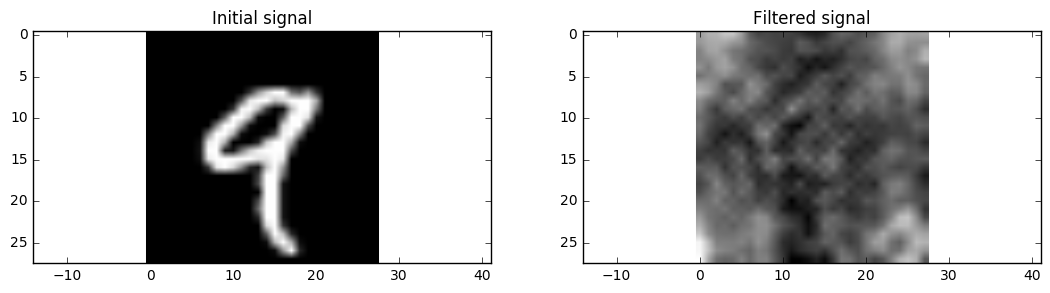

In [39]:
fig = plt.figure(figsize=(13, 3))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, sharey=ax1)

ax1.imshow(x.reshape(mnist.shape), cmap='gray')
ax1.set_title("Initial signal")

ax2.imshow(fast_filter(x, theta, L).reshape(mnist.shape), cmap='gray')
ax2.set_title("Filtered signal")

plt.show()

# Spectral filter in tensorflow

In [40]:
import tensorflow as tf
tf.reset_default_graph()

We first build the filter with symbolic variables

In [41]:
K = 100  # number of filter parameters
theta_tf = tf.Variable(np.array(np.random.uniform(-1, 1, size=(K,1)), dtype=np.float32))
X_tf = tf.placeholder(tf.float32, [None, K])
y_tf = tf.matmul(X_tf, theta_tf)

In [42]:
# function to get the matrix with all chebitchev
def return_X(x, K, L):
    ''' Fast localized spectral filter
    INPUT
        x: input signal in R^d
        K: number of filter parameters
        L: Graph laplacian in R^{d*d}
    OUTPUT
        W matrix with all the chebtichev vectors \bar x_k as columns
    '''
    lambda_max = max(np.linalg.eig(L)[0]) # maximum eigenvalue
    L_tilde = 2*L/lambda_max - np.eye(L.shape[0])
    
    X = np.zeros((x.size, K)) # matrix to store all x_bar's
    X[:, 0] = x
    X[:, 1] = np.matmul(L_tilde, x)
    # compute tchebitchev recursion
    for k in range(2, K):
        X[:, k] = 2 * np.matmul(L_tilde, X[:, k-1]) - X[:, k-2]
    # return tchebitchev
    return X

We now generate the $\bar X$ matrix

In [43]:
X_bar = return_X(x, K, L)

Launch a tensorflow session to retrieve the filtered signal

In [44]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

y_tf_result = sess.run(y_tf, feed_dict={
        X_tf: X_bar, 
        theta_tf: theta.reshape((-1,1))
    })

Plot the results...

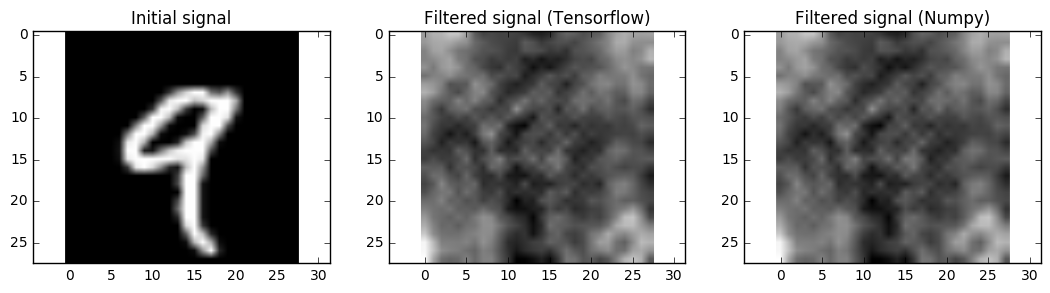

In [45]:
fig = plt.figure(figsize=(13, 3))

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2, sharey=ax1)
ax3 = fig.add_subplot(1, 3, 3, sharey=ax1)

ax1.imshow(x.reshape(mnist.shape), cmap='gray')
ax1.set_title("Initial signal")

ax2.imshow(y_tf_result.reshape(mnist.shape), cmap='gray')
ax2.set_title("Filtered signal (Tensorflow)")

ax3.imshow(fast_filter(x, theta, L).reshape(mnist.shape), cmap='gray')
ax3.set_title("Filtered signal (Numpy)")

plt.show()

We see that the two filters (numpy and tensorflow) give the same results! Fortunately!

# What if we want to learn a filter using Gradient Descent?

To illustrate we will try to learn the inverse filter, that allows to get back to the initial filter from the filtered signal.

We add two tensorflow variables for the target signal and a loss for the gradient descent

In [46]:
y_target = tf.placeholder(tf.float32, [None, 1])
loss_tf = tf.reduce_sum((y_tf - y_target)**2)  # squared differences as loss

We modify the $\bar X$ to take the filtered signal as input

In [47]:
X_bar = return_X(fast_filter(x, theta, L), K, L)

We can first see how bad it is before optimizing $\theta$, that is with a random $\theta$

In [48]:
init = tf.global_variables_initializer()  # will reset theta
sess = tf.Session()
sess.run(init)

[y_tf_result, loss] = sess.run([y_tf, loss_tf], feed_dict={
        X_tf: X_bar, 
         y_target: x.reshape((-1,1))  # the target is the original signal to inverse the filter!
    })

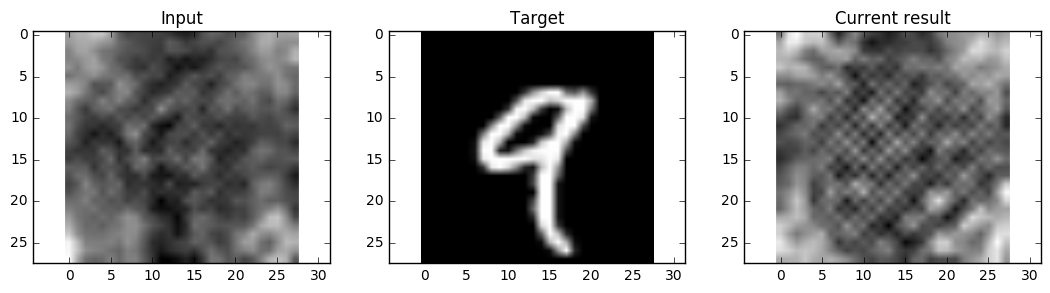

In [49]:
fig = plt.figure(figsize=(13, 3))

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2, sharey=ax1)
ax3 = fig.add_subplot(1, 3, 3, sharey=ax1)

ax1.imshow(fast_filter(x, theta, L).reshape(mnist.shape), cmap='gray')
ax1.set_title("Input")

ax2.imshow(x.reshape(mnist.shape), cmap='gray')
ax2.set_title("Target")

ax3.imshow(y_tf_result.reshape(mnist.shape), cmap='gray')
ax3.set_title("Current result")

plt.show()

We see with the plot that the filtered version is not the same at all than the one we computed using numpy and our fast_filter function. This is totally normal since we initialized our theta_tf at random! We can quantify the difference with the loss:

In [50]:
print("loss before optimizing:", loss)

loss before optimizing: 5432.77


What we will try now is to optimize the theta_tf using Gradient descend to get the original signal back i.e. inverse the filter. Be careful, the gradient descent is really sensitive to the learning rate and may diverge if it is too large.

In [51]:
train_step = tf.train.AdadeltaOptimizer(0.5).minimize(loss_tf, var_list=[theta_tf])

In [52]:
init = tf.global_variables_initializer()  # will reset theta
sess = tf.Session()
sess.run(init)

# do 1000 iteration of the GD
for i in range(10001):
    [current_loss, _] = sess.run([loss_tf, train_step], feed_dict={
            X_tf: X_bar,
            y_target: x.reshape((-1,1))
        })
    if i%1000==0:
        print("{}\tloss: {}".format(i,current_loss,2))

0	loss: 5432.76611328125
1000	loss: 745.59326171875
2000	loss: 124.54069519042969
3000	loss: 31.942596435546875
4000	loss: 19.06565284729004
5000	loss: 16.38789176940918
6000	loss: 15.800607681274414
7000	loss: 15.95989990234375
8000	loss: 16.440624237060547
9000	loss: 17.072839736938477
10000	loss: 17.7820987701416


We can finally retrieve our filtered signal and plot it with our initial filtered signal:

In [53]:
y_tf_result = sess.run(y_tf, feed_dict={
        X_tf: X_bar,
        y_target: x.reshape((-1,1))
    })

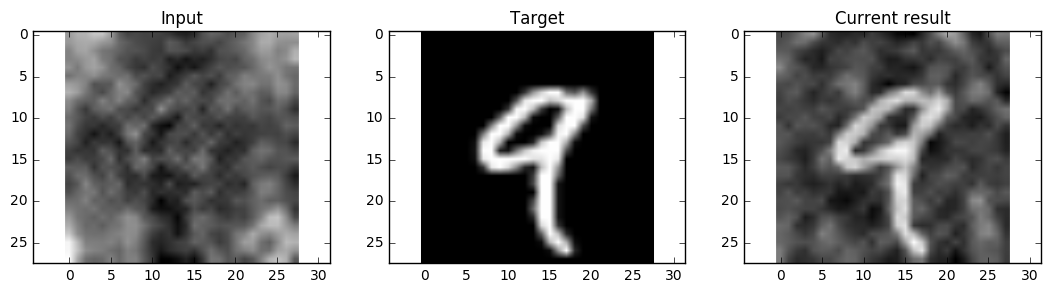

In [54]:
fig = plt.figure(figsize=(13, 3))

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2, sharey=ax1)
ax3 = fig.add_subplot(1, 3, 3, sharey=ax1)

ax1.imshow(fast_filter(x, theta, L).reshape(mnist.shape), cmap='gray')
ax1.set_title("Input")

ax2.imshow(x.reshape(mnist.shape), cmap='gray')
ax2.set_title("Target")

ax3.imshow(y_tf_result.reshape(mnist.shape), cmap='gray')
ax3.set_title("Current result")

plt.show()

We see that the filter learnt well, we are quite close to the original filter

We can also look at the $\theta$ that was learnt:

In [55]:
theta_learnt = sess.run([theta_tf], feed_dict={X_tf: X_bar})[0].reshape((-1))
print("theta learnt", theta_learnt)

theta learnt [ 0.39884639  0.63726497  0.19972128  0.53872895  0.02917032  0.39857948
 -0.21747005  0.2108255  -0.02295584  0.22792156 -0.14029008  0.24510056
 -0.28489274 -0.05974063  0.00221976  0.30694613  0.00211097 -0.07737844
  0.05944965  0.24563648 -0.12050346  0.25381488 -0.06565624 -0.05925493
 -0.18644769  0.28949216 -0.19185717  0.24996692  0.04732389  0.4620735
  0.07705289 -0.02580681  0.08293439  0.01483649 -0.10655338 -0.01610611
 -0.2538918   0.00551973 -0.02798312  0.22332487 -0.24500114 -0.25548613
 -0.34273595 -0.26714712 -0.27523914 -0.2781803  -0.05452728 -0.56307483
  0.22878295 -0.16160658  0.46295443 -0.05513822  0.14531055 -0.33192697
  0.0016164  -0.12294906 -0.08062813 -0.00068708  0.20740503  0.146743
  0.12428366  0.14494251  0.4298881   0.11707547  0.03626133 -0.08323998
  0.14547442 -0.02903176  0.4104512  -0.09400695 -0.03953939 -0.12588848
 -0.03364126 -0.01044432 -0.23420301 -0.35651401 -0.42045978 -0.52369541
 -0.2792421  -0.30948329 -0.22597422 -0.4

## With multiple labelled digits

In [56]:
from tensorflow.examples.tutorials.mnist import input_data
import os
folder = os.path.join('data', 'mnist')
mnist = input_data.read_data_sets(folder, one_hot=True)

Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz


In [57]:
mnist

Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f09d3ccccc0>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f09d3ccc780>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f09d3ccceb8>)

In [71]:
tf.reset_default_graph()
x_tf = tf.placeholder(tf.float32, [784])
K = 100  # number of filter parameters
theta_tf = tf.Variable(np.array(np.random.uniform(-1, 1, size=(K,1)), dtype=np.float32))
X_tf = tf.placeholder(tf.float32, [None, K])
x_tf_filtered = tf.matmul(X_tf, theta_tf)
y_tf = tf.nn.softmax(x_tf_filtered)

In [72]:
y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_tf), reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [73]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

for i in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(1)
    batch_xs=batch_xs.reshape((-1,))
    sess.run(train_step, feed_dict={x_tf: batch_xs, y_: batch_ys, X_tf: X_bar})

In [77]:
tf.shape(y_tf)

<tf.Tensor 'Shape:0' shape=(2,) dtype=int32>

In [83]:
correct_prediction = tf.equal(tf.argmax(y_tf,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x_tf: mnist.test.images[0,:], y_: mnist.test.labels[0:1], X_tf: X_bar}))

0.0
